# Plotting the DFT

In this notebook we will look at the practical issues associated to plotting the DFT and in particular the DFT of real-world signals. We will examine how to map the DFT coefficients to real-world frequencies and we will investigate the frequency resolution of the DFT and the effects of zero padding.
 
As a quick reminder, the definition of the DFT for a length-$N$ signal is:

$$
    X[k] = \sum_{n=0}^{N-1} x[n]\, e^{-j\frac{2\pi}{N}nk}, \quad k=0, \ldots, N-1 
$$

As we have seen, the above formula is just the expression of a change of basis in $\mathbb{C}^N$: we're expressing the information contained in the signal in terms of sinusoidal components rather than in terms of pointwise data. The sinusoidal components have all an integer number of periods over the length of the data signal.

In Python, we will use the `fft` module in Numpy to compute the DFT

In [1]:
# first our usual bookkeeping
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

Typically, we will take a vector of data points, compute the DFT and plot the magnitude of the result. For instance, consider the DFT of a linear ramp:

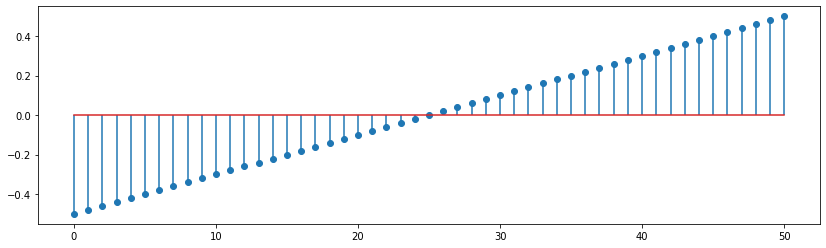

In [3]:
x = np.arange(0, 1.02, 0.02) - 0.5
plt.stem(x, use_line_collection=True);

In [4]:
len(x)

51

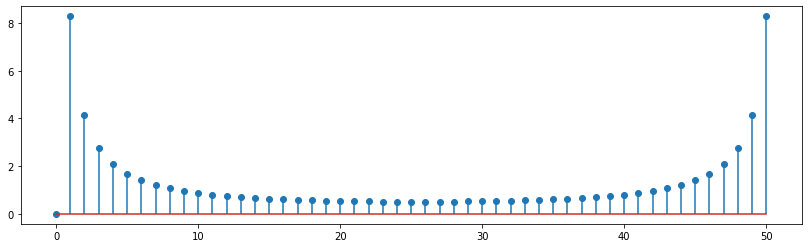

In [6]:
X = np.fft.fft(x);
plt.stem(abs(X), use_line_collection=True);

## Positive and negative frequencies

The coefficient number $k$ indicates the contribution (in amplitude and phase) of a sinusoidal component of frequency

$$
    \omega_k = \frac{2\pi}{N}k
$$

Because of the rotational symmetry of complex exponentials, a positive frequency $\omega$ between $\pi$ and $2\pi$ is equivalent to a negative frequency of $\omega - 2\pi$; this means that half of the DFT coefficients correspond to negative frequencies and when we concentrate on the physical properties  of the DFT it would probably make more sense to plot the coefficients centered around zero with positive frequencies on the right and negative frequencies on the left.

The reason why this is not usually done are many, including
 
 * convenience
 * since we are manipulating finite-length signals, the convention dictates that we start at index zero 
 * when dealing with real-valued data, the DFT is symmetric in magnitude, so the first half of the coefficients is enough
 * if we're looking for maxima in the magnitude, it's just easier to start at zero.

There is also another subtle point that we must take into account when shifting a DFT vector: **we need to differentiate between odd and even length signals**. With $k=0$ as the center point, odd-length vectors will produce symmetric data sets with $(N-1)/2$ points left and right of the origin, whereas even-length vectors will be asymmetric, with one more point on the positive axis; indeed, the highest positive frequency for even-length signals will be equal to $\omega_{N/2} = \pi$. Since the frequencies of $\pi$ and $-\pi$ are identical, we can copy the top frequency data point to the negative axis and obtain a symmetric vector also for even-length signals. 

Here is a function that does that:

In [7]:
def dft_shift(X):
    N = len(X)
    if (N % 2 == 0):
        # even-length: return N+1 values
        return np.concatenate((X[(N/2):], X[:(N/2)+1]))
    else:
        # odd-length: return N values
        return np.concatenate((X[int((N+1)/2):], X[:int((N-1)/2)]))

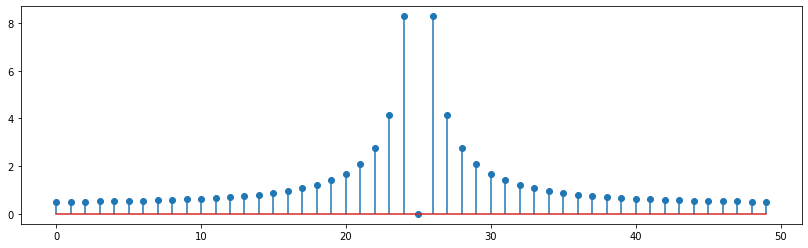

In [8]:
plt.stem(abs(dft_shift(X)), use_line_collection=True);

While the function does shift the vector, the indices are still from zero to $N-1$. Let's modify it so that we returs also the proper values for the indices:

In [9]:
def dft_shift(X):
    N = len(X)
    if (N % 2 == 0):
        # even-length: return N+1 values
        return np.arange(-int(N/2), int(N/2) + 1), np.concatenate((X[int(N/2):], X[:int(N/2)+1]))
    else:
        # odd-length: return N values
        return np.arange(-int((N-1)/2), int((N-1)/2) + 1), np.concatenate((X[int((N+1)/2):], X[:int((N+1)/2)]))

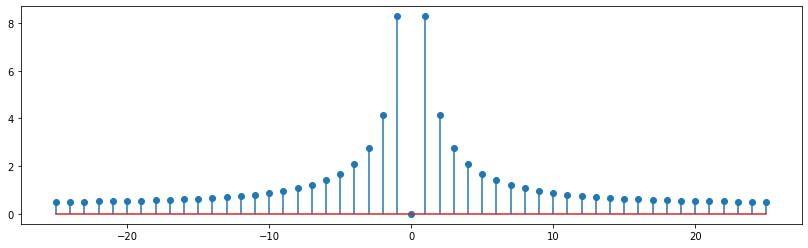

In [10]:
n, y = dft_shift(X)
plt.stem(n, abs(y), use_line_collection=True);

## Mapping the DFT index to real-world frequencies

The next step is to use the DFT to analyze real-world signals. As we have seen in previous examples, what we need to do is set the time interval between samples or, in other words, set the "clock" of the system. For audio, this is equivalent to the sampling rate of the file.

Here for instance is the sound of a piano

In [11]:
import IPython
from scipy.io import wavfile
Fs, x = wavfile.read("piano.wav")
IPython.display.Audio(x, rate=Fs)

In [12]:
Fs

16000

In order to look at the spectrum of the sound file with a DFT we need to map the digital frequency "bins" of the DFT to real-world frequencies. 

The $k$-th basis function over $\mathbb{C}^N$ completes $k$ periods over $N$ samples. If the time between samples is $1/F_s$, then the real-world frequency of the $k$-th basis function is periods over time, namely $k(F_s/N)$.

Let's remap the DFT coefficients using the sampling rate:

In [13]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

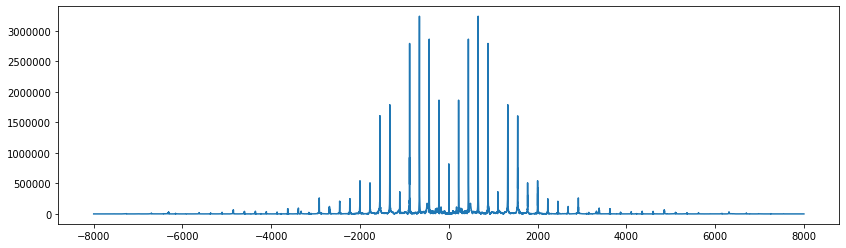

In [14]:
# let's cut the signal otherwise it's too big
x = x[:32768]
X = np.fft.fft(x);
f, y = dft_map(X, Fs)
plt.plot(f, abs(y));

The plot shows what a spectrum analyzer would display. We can see the periodic pattern in the sound, like for all musical tones. If we want to find out the original pitch we need to zoom in in the plot and find the first peak. This is one of the instances in which shifting the DFT does not help, since we'll be looking in the low-frequency range. So let's re-plot withouth the shift, but still mapping the frequencies:

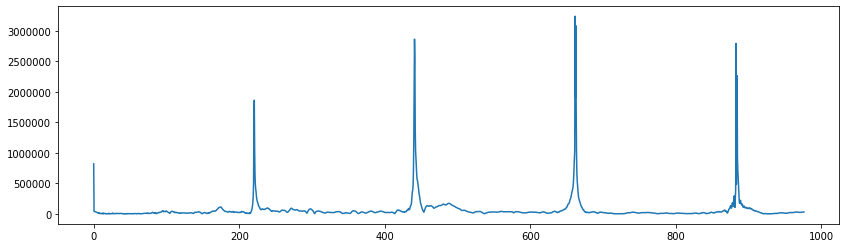

In [16]:
X = np.fft.fft(x);
f, y = dft_map(X, Fs, shift=False)
plt.plot(f[:2000], abs(y[:2000]));

We can see that the first peak is in the vicinity of 200Hz; to find the exact frequency (to within the resolution afforded by this DFT) let's find the location

In [18]:
dft_resolution = float(Fs)/ len(x)
print("DFT resolution is", dft_resolution, "Hz")

# let's search up to 300Hz
max_range = int(300 / dft_resolution)
ix = np.argmax(abs(y[:max_range]))
pitch = f[ix]
print("the note has a pitch of", pitch, "Hz")

DFT resolution is 0.48828125 Hz
the note has a pitch of 220.703125 Hz


so the note is a A, half the frequency of concert pitch.

## Zero-padding

Since the resolution of a DFT depends on the length of the data vector, one may erroneously assume that, by *artificially* extending a given data set, the resulting resolution would improve. Note that here we're not talking about *collecting* more data; rather, we have a data set and we append zeros (or any other constant value) to the end of it. This extension is called zero-padding.

The derivation of why zero-padding does not increase the resolution is detailed in the book. Here we will just present a simple example. 

Assume we're in $\mathbb{C}^N$ with $N=256$. The resolution of the DFT in this space is 

$$
    \Delta = 2\pi/256 \approx 0.0245
$$

Let's build a signal with two sinusoids with frequencies more than $\Delta$ apart and let's look at the spectrum:

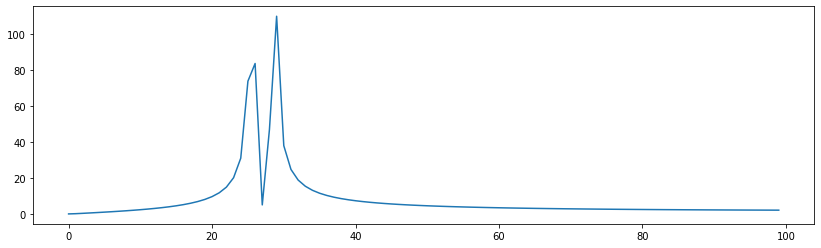

In [19]:
N = 256
Delta = 2*np.pi / N
n = np.arange(0, N)

# main frequency (not a multiple of the fundamental freq for the space)
omega = 2*np.pi / 10 

x = np.cos(omega * n) + np.cos((omega + 3*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100]);

we can tell the two frequencies apart and, if you zoom in on the plot, you will see that they are indeed three indices apart. Now let's build a signal with two frequencies that are less than $\Delta$ apart:

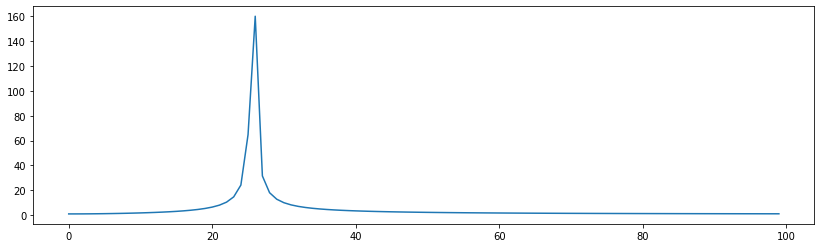

In [20]:
x = np.cos(omega * n) + np.cos((omega + 0.5*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100]);

The two frequencies cannot be resolved by the DFT. If you try to increase the data vector by zero padding, the plot will still display just one peak:

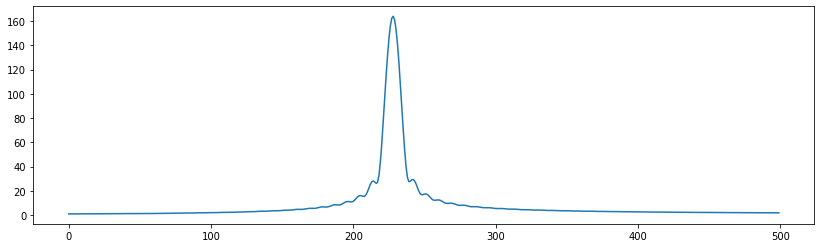

In [21]:
xzp = np.concatenate((x, np.zeros(2000)))
plt.plot(abs(np.fft.fft(xzp))[:500]);